In [127]:
import numpy as np
import h5py
import open3d as o3d
from pathlib import Path
import trimesh
import cv2
import torch
import matplotlib.pyplot as plt
import pprint

from ultralytics import YOLO
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
import smplx

import joblib
from pytorch3d.transforms import (
    rotation_6d_to_matrix,
    matrix_to_quaternion,
    quaternion_to_axis_angle,
)

from src.Network import point_net_ssg
from src.surfaceem import surface_EM_depth
from src.utils import index_points, farthest_point_sample

### Load data and models

In [ ]:
h5file = "demo/demo_lidar/Hong Lidar 13.hdf5"
save_dir = Path(h5file).parent / "frames"
save_dir.mkdir(parents=True, exist_ok=True)
min_amplitude = 0.0

h5 = h5py.File(h5file, "r")

In [136]:
device = "cuda"

# YOLO detection
yolomodel = YOLO("sam_models/yolov8n.pt").to(device)

# Segment anything
sam = sam_model_registry["vit_h"](checkpoint="sam_models/sam_vit_h_4b8939.pth")
mask_predictor = SamPredictor(sam.to(device))

# SMPL
smplmodel_folder = "smpl_models"
gender = "male"  # male/female/neutral
smplmodel = smplx.create(
    smplmodel_folder, model_type="smpl", gender=gender, ext="pkl"
).to(device)
faces = smplmodel.faces

SMPL_meanparams = "./smpl_models/neutral_smpl_mean_params.h5"
depthmodel_path = "./pretrained/model_best_depth.pth"
SMPL_downsample = "./smpl_models/SMPL_downsample_index.pkl"
depthmodel = (
    point_net_ssg(smpl_mean_file=SMPL_meanparams, device=device).to(device).eval()
)
depthmodel.load_state_dict(torch.load(depthmodel_path, map_location=device))

loaded_index = joblib.load(SMPL_downsample)
selected_index = loaded_index["downsample_index"]
depthEM = surface_EM_depth(
    smplxmodel=smplmodel,
    batch_size=1,
    num_iters=100,
    selected_index=selected_index,
    device=device,
)

### Detection and segmentation

In [113]:
idx = 0

key = f"{idx:08d}"
print("showing frame: ", key)
distance = h5["frames"][key]["Distance"][()] / 1000
amplitude = h5["frames"][key]["Amplitude"][()]

dist_image = (distance / distance.max() * 255).astype(np.uint8)
dist_image = np.repeat(dist_image[:, :, np.newaxis], 3, axis=2)
# dist_image = cv2.applyColorMap(dist_image, cv2.COLORMAP_JET)

showing frame:  00000000



0: 480x640 1 person, 1 chair, 4.0ms
Speed: 1.2ms preprocess, 4.0ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


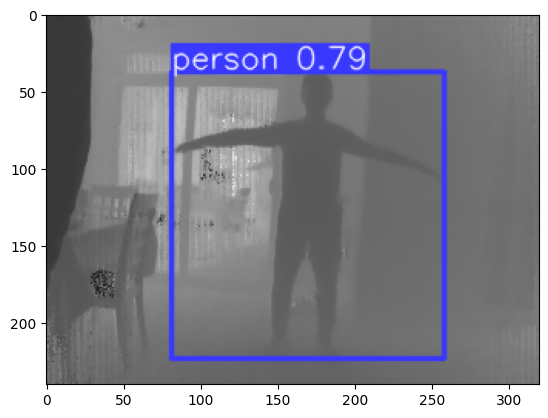

In [114]:
detections = yolomodel(dist_image)[0]
# Find the max person box
detections = detections[detections.boxes.cls == 0]
argmax = torch.argmax(detections.boxes.conf)
box = detections.boxes.xyxy[argmax].data.cpu().numpy()

plt.imshow(detections.plot())
plt.show()

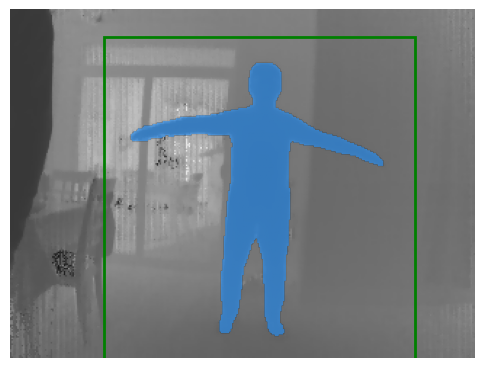

In [115]:
mask_predictor.set_image(dist_image)

# enlarge box by 0.1*width and 0.1*height
scale = 0.1
box[0] = box[0] - scale * (box[2] - box[0])
box[1] = box[1] - scale * (box[3] - box[1])
box[2] = box[2] + scale * (box[2] - box[0])
box[3] = box[3] + scale * (box[3] - box[1])

masks, scores, logits = mask_predictor.predict(box=box, multimask_output=False)
mask = masks[0].astype(np.uint8)


# enlarge the mask with dilation opeartion
def enlarge_mask(mask, ksize=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (ksize, ksize))
    enlarged_mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel)
    return enlarged_mask


mask = enlarge_mask(mask)


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )


plt.figure(figsize=(6, 6))
plt.imshow(dist_image)
show_box(box, plt.gca())
show_mask(mask, plt.gca())
plt.axis("off")
plt.show()

### Depth to point cloud

In [116]:
def create_cloud_from_distance_image(
    distance: np.array, rays: np.array, horizontal_binning: bool, vertical_binning: bool
):
    # map the distance image (m x n) to a point cloud (m x n x 3)
    slicing = [1, 1]
    if horizontal_binning:
        slicing[0] = 2
    if vertical_binning:
        slicing[1] = 2
    # take subset of rays based on binning configuration
    rays_small = rays[:: slicing[1], :: slicing[0], :]
    cloud = distance[..., np.newaxis] * rays_small
    return cloud


rays = h5["recording_information"]["rays"][()]
cloud = create_cloud_from_distance_image(distance, rays, False, False)
keep = (amplitude > 10) & (mask > 0)
min_dist, max_dist = np.quantile(distance[keep], [0.0, 0.9])
keep &= (distance > min_dist) & (distance < max_dist)

cloud = cloud[keep]
print(cloud[:, 2].max(), cloud[:, 2].min())


# normalize the height to [-1, 1]
scale = (cloud[:, 2].max() - cloud[:, 2].min()) * 0.5
cloud /= scale
cloud[:, 2] = (cloud[:, 2] - cloud[:, 2].min()) - 1

# shift depth to 0
cloud[:, 0] -= cloud[:, 0].min()

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(cloud[:, [0, 2, 1]])

# o3d.io.write_point_cloud(str(save_dir / f"{key}.ply"), pcd, write_ascii=False)


1.472835474715415 -1.7313776665547655


In [145]:
# pcd: o3d.geometry.PointCloud = o3d.io.read_point_cloud(
#     f"demo/demo_lidar/frames/{key}.ply"
# )
# pcd_example: o3d.geometry.PointCloud = o3d.io.read_point_cloud(
#     "demo/demo_depth/00003200.ply"
# )

mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=0.6, origin=[-1, -1, 0]
)
o3d.visualization.draw_geometries([pcd, mesh_frame,])

### Point cloud to SMPL

In [137]:
pts = torch.from_numpy(np.asarray(pcd.points)).float()
index = farthest_point_sample(pts.unsqueeze(0), npoint=2048).squeeze()
pts = pts[index]

# move to center
trans = torch.mean(pts, dim=0, keepdim=True)
pts = torch.sub(pts, trans)
point_arr = torch.transpose(pts, 1, 0)
point_arr = point_arr.unsqueeze(0).to(depthmodel.device)
point_arr2 = pts.unsqueeze(0).to(depthmodel.device)

# do the inference
with torch.no_grad():
    pred_shape, pred_pose_body, pred_trans, pred_R6D = depthmodel(point_arr)
pred_R6D_3D = quaternion_to_axis_angle(
    matrix_to_quaternion((rotation_6d_to_matrix(pred_R6D)))
)

pred_pose = torch.zeros(1, 72).to(depthmodel.device)
pred_betas = torch.zeros(1, 10).to(depthmodel.device)
pred_cam_t = torch.zeros(1, 3).to(depthmodel.device)
trans_back = torch.zeros(1, 3).to(depthmodel.device)

pred_pose[0, 3:] = pred_pose_body.unsqueeze(0).float()
pred_pose[0, :3] = pred_R6D_3D.unsqueeze(0).float()
pred_cam_t[0, :] = pred_trans.unsqueeze(0).float()
trans_back[0, :] = trans.unsqueeze(0).float()

pred_pose[0, 16 * 3 : 18 * 3] = torch.Tensor([0, 0, 0, 0, 0, 0]).unsqueeze(0).float()
new_opt_vertices, new_opt_joints, new_opt_pose, new_opt_betas, new_opt_cam_t = depthEM(
    pred_pose.detach(), pred_betas.detach(), pred_cam_t.detach(), point_arr2
)

smpl_output = smplmodel(
    betas=new_opt_betas,
    global_orient=new_opt_pose[:, :3],
    body_pose=new_opt_pose[:, 3:],
    transl=new_opt_cam_t + trans_back,
    return_verts=True,
)
mesh = trimesh.Trimesh(
    vertices=smpl_output.vertices.detach().cpu().numpy().squeeze(),
    faces=smplmodel.faces,
    process=False,
)
# mesh.export(opt.dirs_save + filename_pure + "_EM.ply")

In [146]:
o3d.visualization.draw_geometries([mesh.as_open3d, mesh_frame, pcd])

### Body measurement

In [139]:
from src.extract_measurements import extract_measurements

In [140]:
vertices = smpl_output.vertices.data.cpu().numpy()[0]
extract_measurements(height=170, vertices=vertices)

mesh = trimesh.Trimesh(vertices=vertices, faces=smplmodel.faces, process=False)
mesh.show()

height: 170.000000
waist: 95.101492
belly: 94.289411
chest: 101.919402
wrist: 17.007358
neck: 37.289788
arm length: 52.247515
thigh: 56.504756
shoulder width: 45.723330
hips: 104.163233
ankle: 21.792797


In [141]:
# To A pose
body_pose = torch.zeros_like(smpl_output.body_pose)
body_pose[:, 50 - 3] = 5.6
body_pose[:, 53 - 3] = -5.6

output = smplmodel(betas=smpl_output.betas, body_pose=body_pose)
vertices_a = output.vertices.data.cpu().numpy()[0]

In [142]:
extract_measurements(height=170, vertices=vertices_a)

mesh_a = trimesh.Trimesh(vertices=vertices_a, faces=smplmodel.faces, process=False)
mesh_a.show()

height: 170.000000
waist: 95.942946
belly: 95.686795
chest: 105.750659
wrist: 17.344272
neck: 38.459214
arm length: 54.964220
thigh: 56.545374
shoulder width: 46.036678
hips: 103.426209
ankle: 21.853965


In [130]:
from body_measurements.measurement import Body3D

measurement_names = "height, shoulder_length, chest_length, hip_length, waist_length, thigh_length, outer_leg_length, inner_leg_length, neck_length, neck_hip_length".split(
    ", "
)

In [143]:
body = Body3D(vertices_a, faces)

body_measurements = body.getMeasurements()
pprint.pprint({k: v for k, v in zip(measurement_names, body_measurements[1:])})

{'chest_length': 1.146005162580583,
 'height': 1.8646767786134786,
 'hip_length': 1.1184512490185992,
 'inner_leg_length': 0.73,
 'neck_hip_length': 0.65,
 'neck_length': 0.4533518705190718,
 'outer_leg_length': 0.86,
 'shoulder_length': 0.9983089097768136,
 'thigh_length': 0.6866480103394617,
 'waist_length': 1.0690776671592246}


In [144]:
height = 170
scale = height / body.height()
body_measurements = np.asarray(body.getMeasurements()[1:]) * scale
pprint.pprint({k: v for k, v in zip(measurement_names, body_measurements)})

{'chest_length': 104.4797038677998,
 'height': 170.0,
 'hip_length': 101.96765172060661,
 'inner_leg_length': 66.55308921274673,
 'neck_hip_length': 59.25959998395256,
 'neck_length': 41.33146230605669,
 'outer_leg_length': 78.40500920953723,
 'shoulder_length': 91.0144410058304,
 'thigh_length': 62.60074834229757,
 'waist_length': 97.46633062712742}
